In [1]:
# Ritter IPO Analysis
#   Step 1: Import and Clean Ritter IPO datasets
# pip install wget

#imports
import numpy as np
import pandas as pd
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import wget

In [2]:
# Download Ritter IPO 2609 file
ipo2609_filename = "IPO2609.xls"
url = "https://site.warrington.ufl.edu/ritter/files/2016/01/IPO2609.xls"
wget.download(url, ipo2609_filename)

100% [............................................................................] 828416 / 828416

'IPO2609.xls'

In [3]:
# Download Ritter IPO 1526 file
ipo1526_filename = "IPO1526.xls"
url = "https://site.warrington.ufl.edu/ritter/files/2016/01/IPO1526.xls"
wget.download(url, ipo1526_filename)

100% [..........................................................................] 1399808 / 1399808

'IPO1526.xls'

In [4]:
# Read IPO 2609 Excel file into dataframe
# NOTE:  YOu can igore WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero
df = pd.read_excel(ipo2609_filename, sheet_name='ipo2609')


# Clean Zip Codes and generate zip3
#   Replace 0, 999 with 00000
df['zip'] = df['zip'].astype(str).str.ljust(5, '0')
df['zip'] = df['zip'].replace(
    to_replace=['99900'],
    value='00000')
#      Add trailing zeros so 5 digits
#df['zip'] = pd.Categorical(df['zip'])
#      Use zip3 for region
df['zip3'] = df['zip'].str[:3].astype("int")

#   Security Type: Last two digits of CUSIP represent security type
df['sectype'] = df['cusip'].astype(str).str[-2:].astype("int")

# Convert Categorical
#   Type
#      Create a type code
df['t_code'] = df['t'].copy().astype("int")
#      There are two NA values 0,9.  Use 9 only
df['t_code'] = df['t_code'].replace(
    to_replace=[0],
    value=9)
df['t'] = df['t'].replace(
    to_replace=[0, 9],
    value='NA')
df['t'] = df['t'].replace(
    to_replace=[1],
    value='Best Efforts')
df['t'] = df['t'].replace(
    to_replace=[2],
    value='Firm Committment')
df['t'] = df['t'].replace(
    to_replace=[3],
    value='Combination')
df['t'] = pd.Categorical(df['t'])
#   Exchange
#      Create an exchange code
df['ex_code'] = df['ex'].copy().astype("int")
df['ex'] = df['ex'].replace(
    to_replace=[1],
    value='NASDAQ')
df['ex'] = df['ex'].replace(
    to_replace=[2],
    value='AMEX')
df['ex'] = df['ex'].replace(
    to_replace=[3],
    value='NYSE')
df['ex'] = df['ex'].replace(
    to_replace=[4],
    value='Non_NASDAQ_OTC')
df['ex'] = pd.Categorical(df['ex'])

# Clean Up Integer Fields
df['odate'] = df['odate'].astype("int")
#   SIC Code
#     999 represents missing
df['sic'] = df['sic'].astype("int")
#   Lead Underwriter
#      0 represents missing
df['uw1'] = df['uw1'].astype("int")
#   Other underwriters
df['uw2'] = df['uw2'].astype("int")
df['uw2'] = df['uw3'].astype("int")
df['uw2'] = df['uw4'].astype("int")
df['uwS'] = df['uwS'].astype("int")
# Fix typo in uw5 column name
df = df.rename(columns={'uwS': 'uw5'})
#   Year Organized
#     99 represents missing
df['yr'] = df['yr'].astype("int")
#   Perm (Key to join 1526 file)
df['perm'] = df['perm'].astype("int")

# Convert and scale decimals
#   Offering Price 7.3
df['op'] = df['op'].astype(float) / 1000
#   Closing bid on first aftermarket day 9.5
df['pr1'] = df['pr1'].astype(float) / 100000
#   Value of S&P on Closing Date 5.2
df['sp'] = df['sp'].replace(
    to_replace=[99999],
    value=np.NaN)
df['sp'] = df['sp'].astype(float) / 100
#   Aftermarket standard deviation
df['uncer'] = df['uncer'].replace(
    to_replace=[999],
    value=np.NaN)
df['uncer'] = df['uncer'].astype(float) / 1000
#   Continuousely compounded growth rate
df['gs'] = df['gs'].replace(
    to_replace=[999],
    value=np.NaN)
df['gs'] = df['gs'].astype(float) / 1000
#   Offering as a fraction of shares outstanding
df['of'] = df['of'].replace(
    to_replace=[999],
    value=np.NaN)
df['of'] = df['of'].astype(float) / 100

# Review columns with missing values
# uncer 757
# gs 1506
# of 37
df.isnull().sum()

# Drop columns uncer and gs as well as cusip, zip and uw3,4,5
df = df.drop(['uncer', 'gs', 'cusip', 'zip', 'uw3', 'uw4', 'uw5'], axis=1)

# Drop rows with missing data
df = df[df['op'] != 0]
df = df[df['sic'] != 999]
df = df[df['t'] != 'NA']
df = df[~df['of'].isnull()]

# Calculate D1 percent change in price
df['d1pctchg'] = (df['pr1'] - df['op']) / df['op'] * 100
# Calculate underpriced flag
df['underpriced'] = df['d1pctchg'] > 0

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


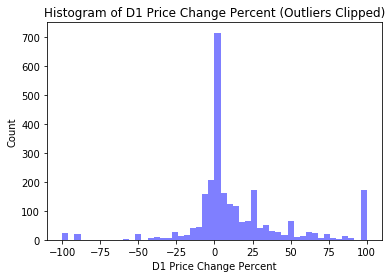

In [5]:
# Plot a Histogram of D1 Price Change Percent
# Remove NaN and Clip Outliers
clipped= np.clip(df['d1pctchg'][~np.isnan(df['d1pctchg'])], -100, 100)
num_bins = 50
n, bins, patches = plt.hist(clipped, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('D1 Price Change Percent')
plt.ylabel('Count')
plt.title(r'Histogram of D1 Price Change Percent (Outliers Clipped)')
plt.show()

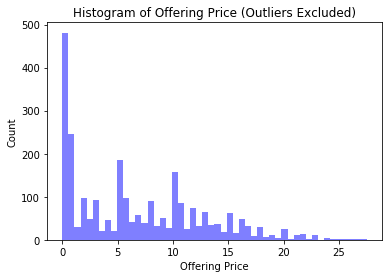

In [6]:
# Simple Outlier implementation based on z-score
def is_outlier(points, thresh=3.0):

    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh


# Plot a Histogram of Offering Price excluding outliers
filtered = df['op'][~is_outlier(df['op'])]
num_bins = 50
n, bins, patches = plt.hist(filtered, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Offering Price')
plt.ylabel('Count')
plt.title(r'Histogram of Offering Price (Outliers Excluded)')
plt.show()

In [7]:
# Join IPO1526 (36 month returns for CRSP-listed)
# Parse columns returns perm and 38 months of returns
df_1526 = pd.read_excel(
    ipo1526_filename, sheet_name='ipo1526', usecols='B,T:BE')

# Replace missing values -100 with NaN for all 38 month return columns
for x in range(1, 39):
    r_col_name = 'r' + str(x)
    df_1526[r_col_name] = df_1526[r_col_name].mask(
        np.isclose(df_1526[r_col_name].values, -99.99998))


# Calculate 12, 24 and 36 month returns
df_1526['r12_sum'] = df_1526.iloc[:, 2:14].sum(axis=1) * 100
df_1526['r24_sum'] = df_1526.iloc[:, 2:26].sum(axis=1) * 100
df_1526['r36_sum'] = df_1526.iloc[:, 2:38].sum(axis=1) * 100

df_1526['r36_sum'].mean()

# Drop r1-r38 columns
for x in range(1, 39):
    r_col_name = 'r' + str(x)
    df_1526.drop(r_col_name, inplace=True, axis=1)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [8]:
# In Professor Ritter's 1991 paper, The Long-Run Performance of Initial Public Offerings
#  he indicates that the average period return for these 1526 stocks
#  in the 3 years after going public is 34.47%
# However, based on the data in the Excel file, I am getting a much higher value (54.10%)
#  At this point, I can see no cause for the discrepancy
#  For the purposes of this experiment, I will ignore this discrepancy
df_1526['r36_sum'].mean()

39.52541677588471

In [9]:
# Merge on Perm
df_1526['perm'] = df_1526['perm'].astype("int")
df_merged = pd.merge(df, df_1526, on='perm')

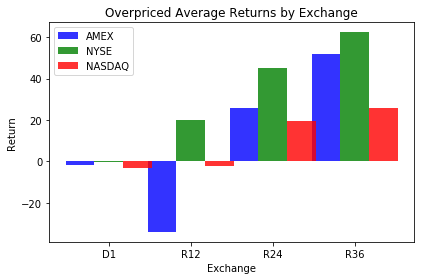

In [10]:
# Plot Bar Charts of Average Returns by Exchange for Overpriced and underpriced

#    Overpriced Chart
df_bar = df_merged[['underpriced', 'ex', 'd1pctchg', 'r12_sum', 'r24_sum', 'r36_sum']]
df_bar = df_bar.groupby(['underpriced', 'ex']).mean()
df_over_amex = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'AMEX')]
df_over_amex = df_over_amex.values.tolist()[0]
df_over_nyse = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'NYSE')]
df_over_nyse = df_over_nyse.values.tolist()[0]
df_over_nasdaq = df_bar.loc[(df_bar.index.get_level_values('underpriced') == False) & (df_bar.index.get_level_values('ex') == 'NASDAQ')]
df_over_nasdaq = df_over_nasdaq.values.tolist()[0]

n_groups = 4
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, df_over_amex, bar_width,
    alpha=opacity,
    color='b',
    label='AMEX')
rects2 = plt.bar(index + bar_width, df_over_nyse, bar_width,
    alpha=opacity,
    color='g',
    label='NYSE')
rects3 = plt.bar(index + bar_width * 2, df_over_nasdaq, bar_width,
    alpha=opacity,
    color='r',
    label='NASDAQ')
plt.xlabel('Exchange')
plt.ylabel('Return')
plt.title('Overpriced Average Returns by Exchange')
plt.xticks(index + bar_width, ('D1', 'R12', 'R24', 'R36'))
plt.legend()
plt.tight_layout()
plt.show()

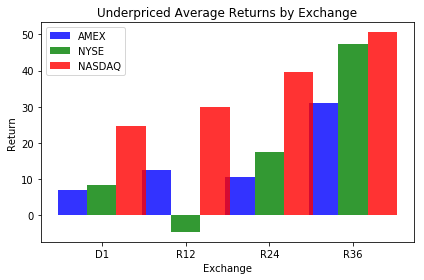

In [11]:
#    UnderPriced Chart
df_under_amex = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'AMEX')]
df_under_amex = df_under_amex.values.tolist()[0]
df_under_nyse = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'NYSE')]
df_under_nyse = df_under_nyse.values.tolist()[0]
df_under_nasdaq = df_bar.loc[(df_bar.index.get_level_values('underpriced') == True) & (df_bar.index.get_level_values('ex') == 'NASDAQ')]
df_under_nasdaq = df_under_nasdaq.values.tolist()[0]

n_groups = 4
fig, ax = plt.subplots()
index = np.arange(n_groups)
rects1 = plt.bar(index, df_under_amex, bar_width,
    alpha=opacity,
    color='b',
    label='AMEX')
rects2 = plt.bar(index + bar_width, df_under_nyse, bar_width,
    alpha=opacity,
    color='g',
    label='NYSE')
rects3 = plt.bar(index + bar_width * 2, df_under_nasdaq, bar_width,
    alpha=opacity,
    color='r',
    label='NASDAQ')
plt.xlabel('Exchange')
plt.ylabel('Return')
plt.title('Underpriced Average Returns by Exchange')
plt.xticks(index + bar_width, ('D1', 'R12', 'R24', 'R36'))
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Step 2: Feature Engineering
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler

# Convert odate to YYYYMM
df['odate'] = df['odate'].astype(str).str[:4].astype("int")

In [13]:
# Univariate Feature Selection
uni_vars=df.columns.values.tolist()

uni_vars.remove('underpriced') # The value we are predicting, so remove from factors
uni_vars.remove('Name') # Company identifier, not relevant
uni_vars.remove('perm') # permanent identifier, not relevant
uni_vars.remove('dt1') # Price after first day trading, unknown at time of prediction
uni_vars.remove('d1pctchg') # Price percent change after first day trading, unknown at time of prediction
uni_vars.remove('ex') # use numeric ex_code
uni_vars.remove('t') # Use numeric t_code
uni_X = df[uni_vars]
uni_y = df['underpriced']

# Apply SelectKBest class to extract top 15 best features
# Use f_classif
bestfeatures = SelectKBest(score_func=f_classif,k=15)
fit = bestfeatures.fit(uni_X, uni_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(uni_X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(15, 'Score'))

       Specs      Score
26   ex_code  20.486920
25    t_code  17.985787
22     audit  13.353715
14        yr  12.668312
1        sel  10.784941
10       min  10.473311
9         sh  10.402267
2        reg   9.910703
23      zip3   9.879382
5        sic   8.962236
21      uses   8.376220
0      odate   8.372649
24   sectype   8.134196
19  expenses   7.186065
11       max   6.295817


In [14]:
# Scale and use chi2
scaler = MinMaxScaler() 
scaled_values = scaler.fit_transform(uni_X) 
scaled_X = uni_X.copy()
scaled_X.loc[:,:] = scaled_values

bestfeatures = SelectKBest(score_func=chi2,k=15)
fit = bestfeatures.fit(scaled_X, uni_y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(scaled_X.columns)
featureScores = pd.concat([dfcolumns, dfscores], axis=1)
featureScores.columns = ['Specs', 'Score']
print(featureScores.nlargest(15, 'Score'))

      Specs      Score
26  ex_code  16.515713
22    audit   6.769405
23     zip3   4.950410
2       reg   3.961824
1       sel   3.655659
24  sectype   3.549752
25   t_code   2.980285
21     uses   2.907307
10      min   1.327842
9        sh   1.072479
5       sic   0.889992
11      max   0.853738
3        op   0.686933
14       yr   0.533424
0     odate   0.427147


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


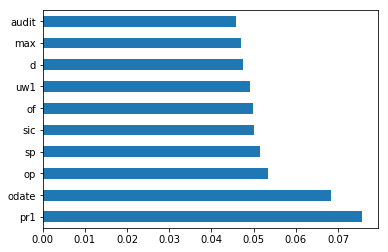

In [15]:
# Feature Importance
model = ExtraTreesClassifier()
model.fit(uni_X, uni_y)
feat_importances = pd.Series(model.feature_importances_, index=scaled_X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

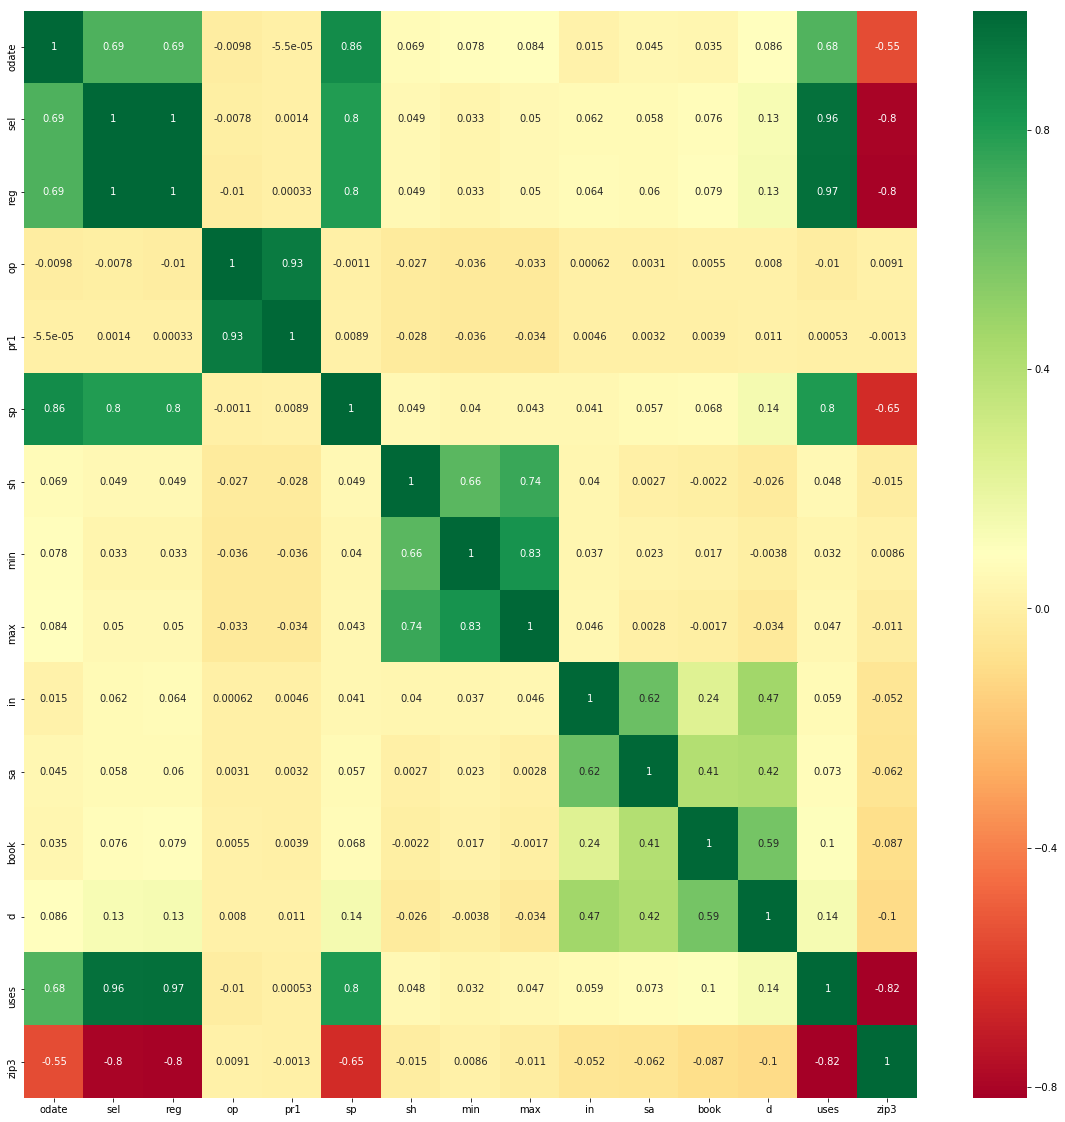

In [16]:
# Correlation Matrix
# get correlations of each features in dataset
cor_X = uni_X.copy()
# Drop columns with insignificant correlations so plot is easier to read
cor_X = cor_X.drop(['uw1', 'uw2', 'sectype', 'of', 'ex_code', 't_code', 'audit', 'risks', 'yr', 'sic', 'lockup', 'expenses'], axis=1)
corrmat = cor_X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(cor_X[top_corr_features].corr(),annot=True,cmap="RdYlGn")
plt.show()